In [242]:
from muFFT import FFT
import muGrid as muG
import numpy as np
import matplotlib.pyplot as plt

#just for better plots
from mpl_toolkits.mplot3d import axes3d,art3d
import scienceplots
import matplotlib as mpl
from matplotlib.animation import FuncAnimation,PillowWriter

from SSP import SpecOps

plt.style.use(['science','dark_background'])
plt.rcParams.update({"figure.figsize": (10,8),
                     "legend.fontsize": 12,
                     "figure.labelsize": 15,
                    "axes.labelsize": 15})

# Milestone 2: Taylor-Green vortex #
In this Milestone, I will implement a spectral solution of the Navier-Stokes equation and test it on a Taylor-Green vortex.

### Navier-Stokes equation ###
You will now implement the first solver for the incompressible Navier-Stokes equations. We use the rotational form of the equations, which is given by
$$
\frac{\partial \vec{u}}{\partial t} = 2 \vec{u}\times\vec{\omega} + \nu \Delta \vec{u} - \nabla P
$$
where $\nu$ is the (kinematic) viscosity and $P(x,y,z)$ the pressure field. The vorticity $2\vec{\omega} = \nabla\times\vec{u}$ was already introduced in the previous milestone. This equation is solved subject to the incompressibility condition
$$ \nabla \cdot \vec{u} = 0$$
We can use this uncompressibility condition to compute the pressure. Taking the divergence of the Navier-Stokes equations and using incompressibility, we obtain the auxiliary equation
$$ \Delta P = 2 \nabla \cdot (\vec{u}\times\vec{\omega})$$
This equation is known as the pressure Poisson equation.

### Task 1: Spectral Navier-Stokes equations ###
To rewrite the Navier-Stokes equation (NSe) in spectral form, we first can use the Pressure-Poisson equation to obtain an expression for $\hat{P}$.
$$ \hat{P} = -\frac{2i}{|\vec{q}|^2} \vec{q} \cdot (\widehat{\vec{u} \times \vec{\omega}})
$$
To obtain the full spectral form, we now simply can Fourier-Transform the NSe.
$$
\frac{\partial \hat{\vec{u}}}{\partial t} = 2 (\widehat{\vec{u}\times\vec{\omega}}) - \nu |\vec{q}|^2 \hat{\vec{u}} - \frac{2}{|\vec{q}|^2} \vec{q} ( \vec{q}\cdot (\widehat{\vec{u}\times\vec{\omega}}))
$$

### Task 2: Fourth-Order Runge-Kutta time stepping ###



In [243]:
def rk4_fourier(f, t: float, y: np.ndarray, dt: float) -> np.ndarray:
    """
    Implements the fourth-order Runge-Kutta method for numerical integration
    of multidimensional fields.

    Parameters
    ----------
    f : function
        The function to be integrated. It should take two arguments: time t
        and field y.
    t : float
        The current time.
    y : array_like
        The current value of the field.
    dt : float
        The time step for the integration.

    Returns
    -------
    dy : np.ndarray
        The increment of the field required to obtain the value at t + dt.
    """
    k1 = f(t, y)
    k2 = f(t + dt / 2, y + dt / 2 * k1)
    k3 = f(t + dt / 2, y + dt / 2 * k2)
    k4 = f(t + dt, y + dt * k3)
    return dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

### Task 3: Analytic Solution ###
A 2D analytic solution of the Navier-Stokes equation is given by the sinusodial Taylor-Green-Vortex. This is a periodic velocity field  $\vec{u}$, living in the $x,y$-plane.

$$
\vec{u}(\vec{x},t) = \left(\begin{array}{c} A(t) \cos(ax)\sin(by) \\ B(t) \sin(ax)\cos(by) \\ 0 \end{array} \right)
$$

Where $A,B,a,b$ are factors, which have to be determined by initial conditions. The first of these is the incompressibility of the Fluid:

$$
\nabla \cdot \vec{u} = 0
$$
This leads to the condition

$$
Aa+Bb = 0
$$

If we choose $a=b=1$ (which will later imply, that the shape of our domain will be rectangular, with a side length of $L = 2\pi$), we get the condition, that

$$ A(t) = -B(t)$$

Thus $\vec{u}(\vec{x},t)$ becomes 
$$ 
\vec{u}(\vec{x},t) = A(t) \left( \begin{array}{c} \cos(ax)\sin(ay) \\ -\sin(ax)\cos(by) \\ 0   \end{array} \right)
$$
Now the task will be to find the prefactor $A(t)$ , using the Navier-Stokes equation. In fact, using the Taylor-Green-Vortex ansatz, the NSe in Fourier-Space will simplify to 

$$
\frac{\partial  \hat{\vec{u}}}{\partial t} = -\nu |\vec{q}|^2 \hat{\vec{u}}
$$

because the non-linear term and the  negative pressure gradient will cancel out. By transforming and inserting $\vec{u}(\vec{x},t)$ in this equation, one gets a simple differential equation, which can be solved by separation of variables to find $A(t)$.

$$
A(t) = A_0 e^{-\nu |\vec{q}|^2 t}, \qquad A_0 = A(0)
$$

With further analysis of the explicit Fourier-Transform of $\vec{u}$, one can ontain the condition, that $a$ has to be equal to $q_x$ and $q_y$ in order to get a non-zero solution. Putting this all together, one gets the final analytic result:
$$
\vec{u}(\vec{x},t) = A_0 \left( \begin{array}{c} \cos(x)\sin(y) \\ -\sin(x)\cos(y) \\ 0  \end{array} \right) e^{-2\nu t}
$$

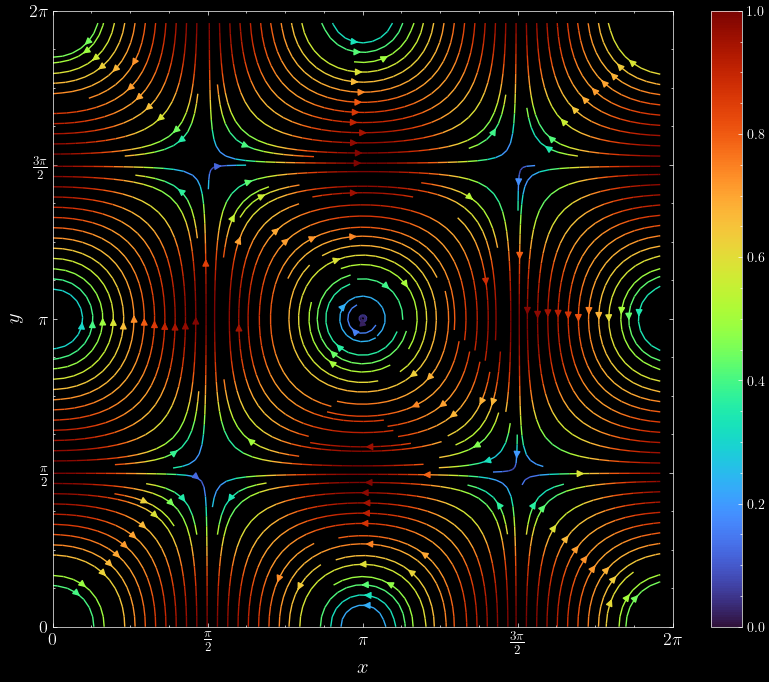

In [244]:
'''Computing and Plotting the analytical Solution'''


A_0 = 1

nu = 1

L = 2*np.pi
N = 50
dx = L/N
dy = L/N

ticks_label = [r"$0$",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
ticks = [0,np.pi/2,np.pi,3*np.pi/2,2*np.pi]

dt = 0.01
t_end = 4


x = np.arange(0,L,dx)
y = np.arange(0,L,dy)
t = np.arange(0,t_end,dt)

X,Y = np.meshgrid(x,y)

u = np.zeros((2,len(t),*X.shape))

for i in range(len(t)):
    u[0,i,:,:] = A_0 * np.cos(X)*np.sin(Y)*np.exp(-2*nu*t[i])
    u[1,i,:,:] = -A_0 * np.sin(X)*np.cos(Y)*np.exp(-2*nu*t[i])


amp = np.sqrt(u[0]**2+u[1]**2)

fig,ax = plt.subplots()
p = plt.streamplot(X,Y,u[0,0],u[1,0],density = 2,color = amp[0],cmap = "turbo")
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_label,fontsize = 13)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_label,fontsize = 13)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
fig.colorbar(plt.cm.ScalarMappable(cmap= plt.cm.turbo),ax = ax)


In [245]:
'''Creating a simulation of the ANALYTIC solution with evolving time'''

# norm = mpl.colors.Normalize(vmin = 0,vmax = 1)

# fig,ax = plt.subplots(1,1)
# p = ax.quiver(X,Y,u[0,0],u[1,0],amp[0],cmap = "Blues", norm = norm)
# ax.set_xticks(ticks)
# ax.set_xticklabels(ticks_label,fontsize = 13)
# ax.set_yticks(ticks)
# ax.set_yticklabels(ticks_label,fontsize = 13)
# ax.set_xlabel(r"$x$")
# ax.set_ylabel(r"$y$")
# fig.colorbar(p) 


# def animate(i):
#     ax.clear()
#     p = ax.quiver(X,Y,u[0,i],u[1,i],amp[i],cmap = "Blues", norm = norm)
    
   

# ani = FuncAnimation(fig, animate, frames= len(t),repeat=False)


# ani.save("Taylor_Green_fwtime.gif", dpi=300,
#          writer=PillowWriter(fps=5))
# plt.draw()
# plt.show()

'Creating a simulation of the ANALYTIC solution with evolving time'

In [246]:
'''3D Plot of the ANALYTIC solution with time as the z-axis'''
# Xt,Yt,T = np.meshgrid(x,y,t)

# u_t = np.zeros((3,*X.shape,len(t)))
# u_t[0] = A_0 * np.cos(Xt)*np.sin(Yt)*np.exp(-2*nu*T)
# u_t[1] = -A_0 * np.sin(Xt)*np.cos(Yt)*np.exp(-2*nu*T)
# u_t[2] = np.zeros_like(Xt)

# ampt = np.sqrt(u_t[0]**2+u_t[1]**2+u_t[2]**2)

# fig = plt.figure(figsize = (10,10))
# ax = fig.add_subplot(projection='3d')
# ax.set_xticks(ticks)
# ax.set_xticklabels(ticks_label,fontsize = 13)
# ax.set_yticks(ticks)
# ax.set_yticklabels(ticks_label,fontsize = 13)
# ax.set_xlabel(r"$x$")
# ax.set_ylabel(r"$y$")
# ax.set_zlabel(r"$t$")
# q = ax.quiver(Xt, Yt, T, u_t[0], u_t[1], u_t[2], length=0.5,color = plt.cm.Blues(ampt.ravel()), cmap='jet', lw=2)
# fig.colorbar(plt.cm.ScalarMappable(cmap= plt.cm.Blues),ax = ax,shrink = 0.6)
# plt.savefig("Analytic_solution_TGVortex.jpg")
# plt.show()

'3D Plot of the ANALYTIC solution with time as the z-axis'

### Task 4: Implementation of the numerical solution ###





In [247]:
#initiate periodic domain
nb_grid_points = (35,35,2)
nx,ny,nz = nb_grid_points

physical_sizes = (2*np.pi,2*np.pi,2*np.pi)
lx,ly,lz = physical_sizes

Props = SpecOps(nb_grid_points,physical_sizes,nu) #get Properties and and methods of SSP class

#get wavevector
q = Props.fft.fftfreq*2*np.pi
q[0]/=Props.gs[0] #Normalize Wavevectors
q[1]/=Props.gs[1]
q[2]/=Props.gs[2]

qx = q[0]
qy = q[1]
qz = q[2]

#get real field coordinates
x,y,z = Props.cords

#set up time domain
dt = 0.001
t_end = 0.1
t = np.arange(0,t_end,dt)


def rhs(t,u):
    '''Computes the right-hand side of the NSe for a given field u and time t'''
    
    #set up the final right-hand-sinde field objects
    uges = Props.fft.real_space_field('uges',(3,))
    uges_hat = Props.fft.fourier_space_field('uges_hat',(3,))

    
    
    #transform u to Fourier-space
    urf = Props.fft.real_space_field("u_real_field",(3,))
    u_hat = Props.fft.fourier_space_field("u_hat",(3,))

    
    urf.p = u #fill real field with u

    Props.fft.fft(urf,u_hat) #transform u for later usage
   



    #compute non linear term in real space and transform to Fourier-space
    uxomega = Props.fft.real_space_field('uxomega',(3,))
    uxomega_hat = Props.fft.fourier_space_field('uxomega_hat',(3,))


    omega = 1/2*Props.curl(u) # w = 1/2 nabla x u
   
    uxomega.p = 2*np.cross(u,omega,axisa=0,axisb=0,axisc=0)
    #compute vector-product term 2u x w

    
   


    Props.fft.fft(uxomega,uxomega_hat) #Transform nonlinear term
    
    #compute diffusing term in Fourier-space directly
    diffu_hat = -nu*(qx**2+qy**2+qz**2)*u_hat.p
 
    #compute Pressurefield in Fourier-space
    P_hat = -2j/(qx**2+qy**2+qz**2)*(qx*uxomega_hat.p[0]+qy*uxomega_hat.p[1]+qz*uxomega_hat.p[2])
    P_hat[0,0,0] = 0 #Fix singularity due to qx=qy=qz=0 

    #compute Pressure Gradient in Fourier-space
    Pgrad_hat = np.zeros((3,*P_hat.shape),dtype = 'complex')
    Pgrad_hat[0] = 1j*P_hat*qx
    Pgrad_hat[1] = 1j*P_hat*qy
    Pgrad_hat[2] = 1j*P_hat*qz

    #sum up all calculated term to get the  numerical right hand side of the equation and normalize
    uges_hat.p = (uxomega_hat.p+diffu_hat-Pgrad_hat)*Props.fft.normalisation

    Props.fft.ifft(uges_hat,uges) #Backtransform rhs to get the real field for time propagation in real space
    
    return uges.p

(3, 35, 35, 2)


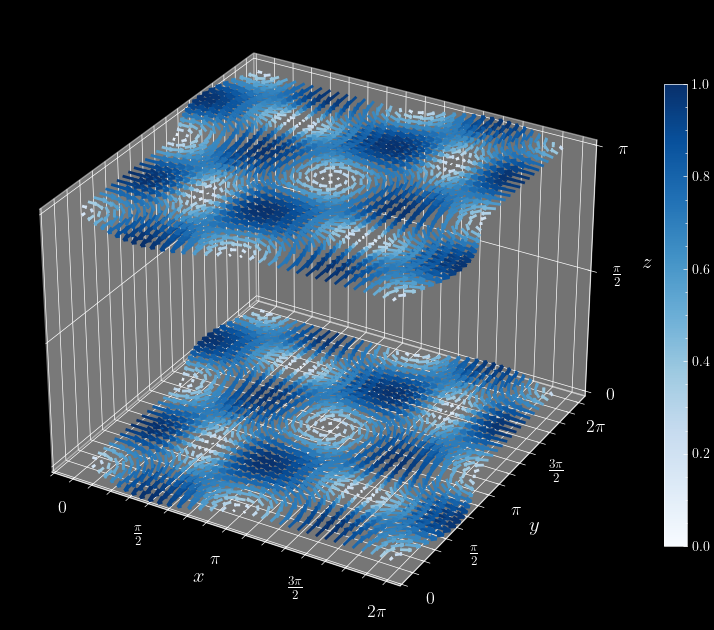

In [248]:
'''Set up initial conditions for u'''

A = 1

u0 = np.zeros((3,*nb_grid_points))
u0[0,:,:,:] = A*np.cos(x)*np.sin(y)
u0[1,:,:,:] = -A*np.sin(x)*np.cos(y)
u0[2,:,:,:] = np.zeros(nb_grid_points)

print(u0[:,:,:,:].shape)

ampu0 = np.sqrt(u0[0]**2+u0[1]**2+u0[2]**2)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_label,fontsize = 13)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_label,fontsize = 13)
ax.set_zticks(ticks)
ax.set_zticklabels(ticks_label,fontsize = 13)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$z$")
vortex = ax.quiver(x, y, z, u0[0], u0[1], u0[2], length=0.5,color = plt.cm.Blues(ampu0.ravel()), cmap='jet', lw=2)
fig.colorbar(plt.cm.ScalarMappable(cmap= plt.cm.Blues),ax = ax,shrink = 0.6)
plt.show()

In [249]:
#Propagte u0 through time

unum = np.zeros((len(t),*u0.shape))
unum[0] = u0

for i in range(len(t)-1):
    unum[i+1] = unum[i] + SpecOps.Runge_Kutta_4(Props,SpecOps.rhs,t[i],unum[i],dt)

unum.shape


/home/johann_gockel/SSP/SSP.py:197: RuntimeWarning: divide by zero encountered in divide
  P_hat = -2j/(self.qx**2+self.qy**2+self.qz**2)*(self.qx*uxomega_hat.p[0]+self.qy*uxomega_hat.p[1]+self.qz*uxomega_hat.p[2])
/home/johann_gockel/SSP/SSP.py:197: RuntimeWarning: invalid value encountered in divide
  P_hat = -2j/(self.qx**2+self.qy**2+self.qz**2)*(self.qx*uxomega_hat.p[0]+self.qy*uxomega_hat.p[1]+self.qz*uxomega_hat.p[2])
/home/johann_gockel/SSP/SSP.py:197: RuntimeWarning: invalid value encountered in multiply
  P_hat = -2j/(self.qx**2+self.qy**2+self.qz**2)*(self.qx*uxomega_hat.p[0]+self.qy*uxomega_hat.p[1]+self.qz*uxomega_hat.p[2])


(100, 3, 35, 35, 2)

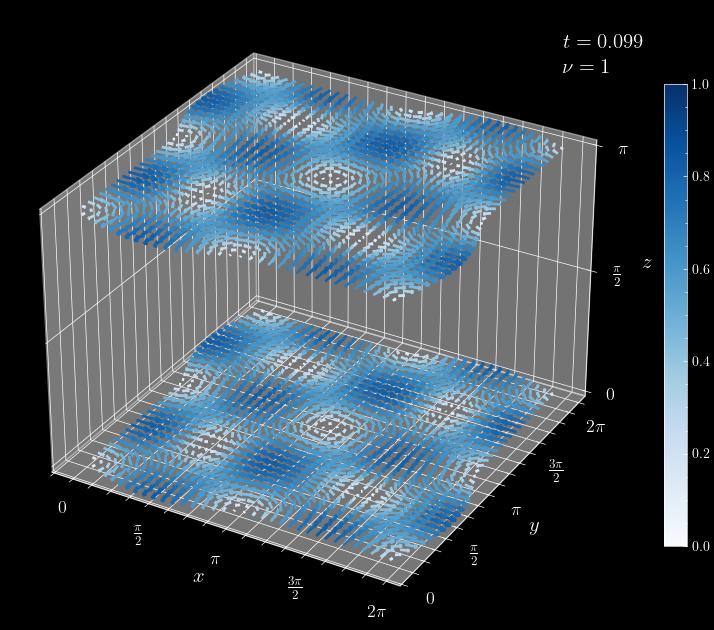

In [250]:
ts = 99
amp = SpecOps.mappable_color_amp(unum[ts],plt.cm.Blues)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_label,fontsize = 13)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_label,fontsize = 13)
ax.set_zticks(ticks)
ax.set_zticklabels(ticks_label,fontsize = 13)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$z$")
ax.text2D(y=0.93, x=0.9, s=r"$t = {t:.4}$".format(t=t[ts]),  transform=ax.transAxes,fontsize = 15)
ax.text2D(y=0.89, x=0.9, s=r"$\nu = {nu}$".format(nu = nu),  transform=ax.transAxes,fontsize = 15)
vortex = ax.quiver(x, y, z, unum[ts,0], unum[ts,1], unum[ts,2], length=0.5,color = amp, cmap='jet', lw=2)
fig.colorbar(plt.cm.ScalarMappable(cmap= plt.cm.Blues),ax = ax,shrink = 0.6)
plt.show()

In [251]:
# norm = mpl.colors.Normalize(vmin = 0,vmax = 1)
# amp = np.zeros((len(t),*SpecOps.mappable_color_amp(unum[0],plt.cm.Blues).shape))

# for i in range(len(t)):
#     amp[i] = SpecOps.mappable_color_amp(unum[i],plt.cm.Blues)

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')
# ax.set_xticks(ticks)
# ax.set_xticklabels(ticks_label,fontsize = 13)
# ax.set_yticks(ticks)
# ax.set_yticklabels(ticks_label,fontsize = 13)
# ax.set_zticks(ticks)
# ax.set_zticklabels(ticks_label,fontsize = 13)
# ax.set_xlabel(r"$x$")
# ax.set_ylabel(r"$y$")
# ax.set_zlabel(r"$z$")
# vortex = ax.quiver(x, y, z, unum[0,0], unum[0,1], unum[0,2], length=0.5,color = amp[0], lw=2,norm = norm)
# fig.colorbar(plt.cm.ScalarMappable(cmap= plt.cm.Blues),ax = ax,shrink = 0.6)




# def animate(i):
#     ax.clear()
#     vortex = ax.quiver(x, y, z, unum[i,0], unum[i,1], unum[i,2], length=0.5,color = amp[i], lw=2,norm = norm)
#     ax.text2D(y=0.93, x=0.9, s=r"$t = {t:.4}$".format(t=t[i]),  transform=ax.transAxes,fontsize = 15)
#     ax.text2D(y=0.89, x=0.9, s=r"$\nu = {nu:.4}$".format(nu = float(nu)),  transform=ax.transAxes,fontsize = 15)
#     print(f"Progress: {i/len(t)*100:.3}%")
    
    
   

# ani = FuncAnimation(fig, animate, frames= np.arange(0,len(t),4),repeat=False)


# ani.save("Taylor_Green_numerical_fwtime.gif", dpi=300,writer=PillowWriter(fps = 10))
# print("Progress: 100%")

### Comparison of the analytic and the numerical solutions ###


In [252]:
'''Generate analytic solution array to compare with (same shape)'''
A_0 = 1

L = 2*np.pi
nx = 35
ny = 35
nz = 2

dx = L/nx
dy = L/ny
dz = L/nz


x = np.arange(0,L,dx)
y = np.arange(0,L,dy)
z = np.arange(0,L,dz)


X,Y,Z = np.meshgrid(x,y,z)

uana = np.zeros((len(t),3,*X.shape))

for i in range(len(t)):
    uana[i,0,:,:,:] = A_0 * np.cos(X)*np.sin(Y)*np.exp(-2*nu*t[i])
    uana[i,1,:,:,:] = -A_0 * np.sin(X)*np.cos(Y)*np.exp(-2*nu*t[i])
    uana[i,2,:,:,:] = np.zeros_like(Z)

uana.shape

(100, 3, 35, 35, 2)

In [253]:
#test shapes of unum and uana
if uana.shape == unum.shape:
    print("We're good")
else:
    print("Something's wrong, I can feel it")

We're good


To get an estimation of the deviation between the analytical and the numerical solution, I will first calculate the Amplitudes of both vector fields for every time step.
Then the arrays will be flattend und summed up for every time step. The absolute difference of the flattend and summed amplitudes for each time step will show the deviations of both solutions, when propagated through time. 

In [254]:

uana_amp = np.zeros((len(t),*unum[0,0,:,:,:].shape))
unum_amp = np.zeros((len(t),*unum[0,0,:,:,:].shape))

#calculate the amplitude fields of the analytic and the numerical field
for i in range(len(t)):
    uana_amp[i] = np.sqrt(uana[i,0]**2+uana[i,1]**2+uana[i,2]**2)
    unum_amp[i] = np.sqrt(unum[i,0]**2+unum[i,1]**2+unum[i,2]**2)

uana_amp_flat = np.zeros_like(t)
unum_amp_flat = np.zeros_like(t)

#calculate the sum of the flattened amplitude fields for every time step
for i in range(len(t)):
    unum_amp_flat[i] = sum(unum_amp[i].flatten())
    uana_amp_flat[i] = sum(uana_amp[i].flatten())


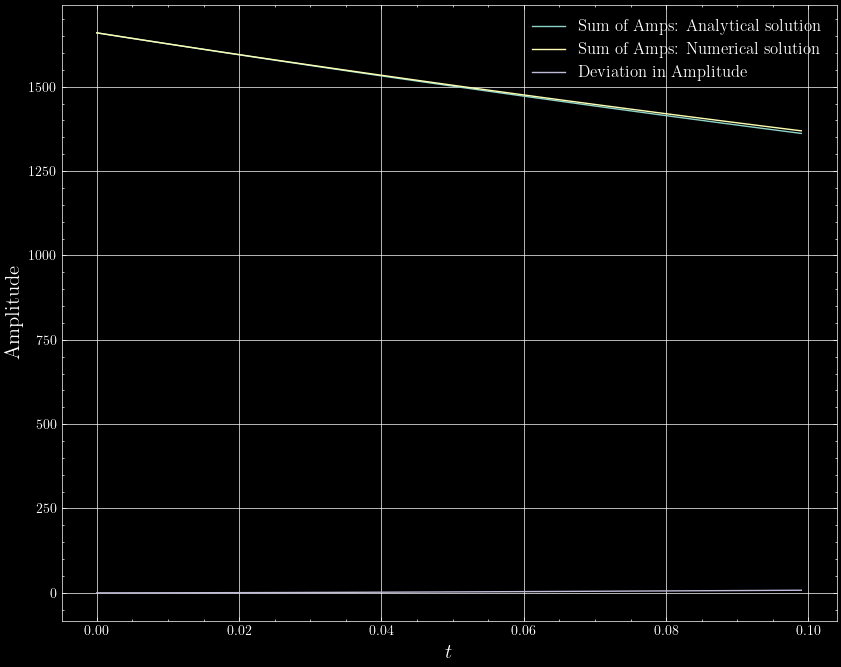

In [255]:
plt.figure()
plt.plot(t,uana_amp_flat, label = "Sum of Amps: Analytical solution")
plt.plot(t,unum_amp_flat, label = "Sum of Amps: Numerical solution")
plt.plot(t,abs(unum_amp_flat-uana_amp_flat),label = 'Deviation in Amplitude')
plt.ylabel(r"Amplitude")
plt.xlabel(r"$t$")
plt.legend()
plt.grid()


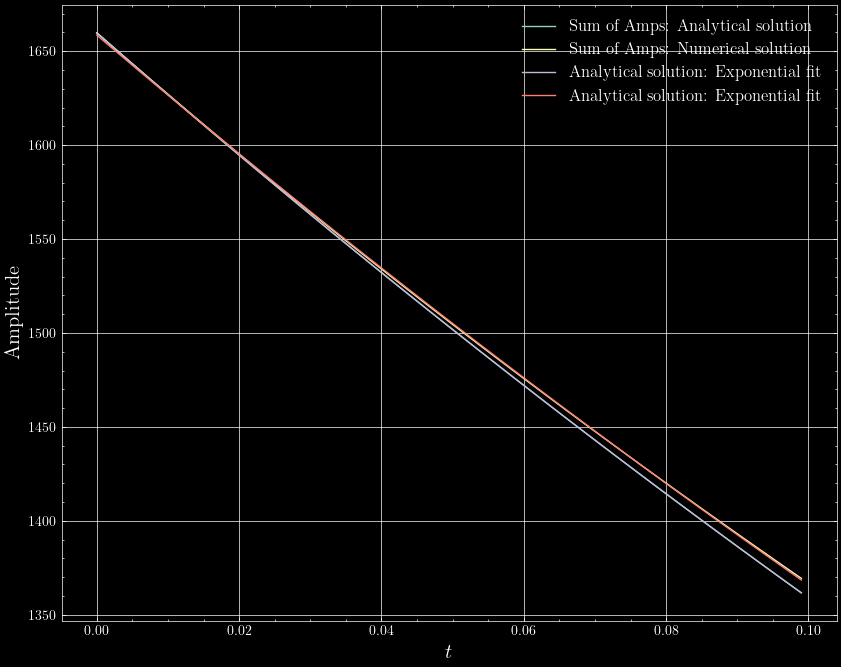

In [256]:
#Fitting both progressions in time to the expected time evolution shape (exonential decay)
from scipy.optimize import curve_fit
def exponential_fit(x,nu,A):
    return A*np.exp(-x*nu)

params0 = (2,1625)
b_ana,cov_ana = curve_fit(exponential_fit,t,uana_amp_flat,params0)

b_num,cov_num = curve_fit(exponential_fit,t,unum_amp_flat,params0)

plt.figure()
plt.plot(t,uana_amp_flat, label = "Sum of Amps: Analytical solution")
plt.plot(t,unum_amp_flat, label = "Sum of Amps: Numerical solution")
plt.plot(t,exponential_fit(t,b_ana[0],b_ana[1]),label = 'Analytical solution: Exponential fit')
plt.plot(t,exponential_fit(t,b_num[0],b_num[1]),label = 'Analytical solution: Exponential fit')
plt.ylabel(r"Amplitude")
plt.xlabel(r"$t$")
plt.legend()
plt.grid()


This shows, that the analytical and especially the numerical solutions are both just expnential functions with slightly differing Amplitude and exponent. The deviations are caused by the errors, arising when calculating the field and propagating the field through time numerically. Now further error analysis (e.g. $\chi^2$ test) is possible, if one wants to pursue this.

In [257]:
print(r"Parameter|",r"Analytical",r"Numerical",r"Absolute Difference")
print('----------------------------------------------------------------')
print(r"nu|q|^2  |",b_ana[0],b_num[0],abs(b_ana[0]-b_num[0]))
print('----------------------------------------------------------------')
print(r"Amplitude|",b_ana[1],b_num[1],abs(b_ana[1]-b_num[1]))

Parameter| Analytical Numerical Absolute Difference
----------------------------------------------------------------
nu|q|^2  | 2.00000000000001 1.9420477847237376 0.05795221527627259
----------------------------------------------------------------
Amplitude| 1659.7796059356613 1658.5499298410614 1.2296760945998813
